# Recommendation system for movies

In [3]:
%matplotlib inline
from collections import defaultdict
import json
import gzip
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

from sklearn.metrics import mean_squared_error
from surprise import NMF
from surprise import Reader, Dataset

## Goals

In this case, you will create a **recommendation system** for movies using **[collaborative filtering](http://en.wikipedia.org/wiki/Collaborative_filtering) (CF)**. Collaborative filtering is built upon users' reviews on a list of items and utilizes users' past behavior to recommend items that they haven't tried yet but might be interested in.

There are two primary approaches to CF: **neighborhood-based comparison** and **latent factor modeling**. The former is concerned with computing the relationships between items or between users. In the latter approach, you have a model of hidden factors through which users and items are transformed to the same space. For example, if you are rating movies we may transform items into different genres and users into their preference for a particular genre. By the end of the case, you will learn how to do CF using both approaches.

## Introduction

**Business Context.** Most online commercial enterprises use automated recommendation systems to increase customer engagement. An efficient and accurate recommendation system connects customers with businesses and services that they have never used before, but would very likely engage with. You are the chief engineer of a start-up company that aims to provide personalized entertainment experiences. Your firm wants you to build a recommendation system that suggests movies and TV shows that cater to users' tastes.

**Business Problem.** Your main task is to use the reviews your users have written for movies and TV shows in Amazon **to build an automatic recommendation system that predicts how likely it is that a user will enjoy a movie, based on which you will also generate a list of movies/TV shows the user has never seen before but would likely enjoy.**

**Analytical Context.** The outline of this case is as follows: we will (1) create a database of item-item similarities and use this to implement a neighborhood-based CF recommender that can answer simple questions like "give me more movies like this one". This part of the case assumes that the similarities calculated make good "global recommendations"; (2) go one step further and attempt to predict the rating that a user will give a movie they have not seen before. This requires that we find the movies that *this* user would rate as similar (not just those which are similar across the board); and finally (3) implement a latent factor-based CF recommender using a non-negative matrix factorization.

## Neighborhood Based Comparison vs. Latent Factors

As mentioned before, there are two primary approaches to CF: **neighborhood-based comparison** and **latent factor modeling**.

Original approaches to neighborhood-based CF used user-user models. This means that we would estimate the rating a particular user would give a particular item based on actual ratings that other, similar users gave that item. However, since most users tend to rate very few items, this is usually not the best way to construct ratings-focused recommendation systems. Thus, most neighborhood-based systems these days (e.g. Amazon) rely on item-item approaches. In this approach, a rating is estimated using rating that the particular user gave other, similar items; i.e. we effectively have a sort of $k$-nearest neighbors algorithm.

Latent factor models generally lead to more accurate recommendations. One of the reasons for this is the sparsity of the item-user matrix. Most users tend to rate barely one or two items. Latent factor models are more expressive, and fit fewer parameters. However, neighborhood models are more prevalent, as they have an intuitive aspect that appeals to users (if you liked this you will like that) and on-line (a new preference can be incorporated very quickly).

## Exploring the dataset

The data we are using is a reduced version of the Amazon movie and TV reviews (available [here](http://jmcauley.ucsd.edu/data/amazon/)). Each entry in this DataFrame is a specific review where we only record user ID, movie ID, and movie rating. We also have a list of metadata which can be used to map movie IDs to actual movie titles:

In [4]:
# dictionary to map movie ids to movie titles
movie_title_dict = {}
with gzip.open('meta_Movies_and_TV.json.gz', 'rt', encoding='ascii') as zipfile:
    for line in zipfile:
        tmp = json.loads(line)
        try:
            movie_title_dict[tmp['asin']] = tmp['title']
        except KeyError:
            continue

In [5]:
fulldf=pd.read_csv("amazon_movie_reviews.csv")
fulldf.head(2)

,item,user,rating
0,0001527665,A3478QRKQDOPQ2,5.0
1,0001527665,A2VHSG6TZHU1OB,5.0


In [6]:
fulldf.shape

(4382784, 3)

The data fields in this DataFrame are:

* **rating**: star rating (integer 1 - 5)
* **item**: unique ID for a movie
* **user**: unique ID for a user

### Exercise 1:

In this data set, how many users have more than one review for a single movie? For these users, do they always give the same rating for the same movie? If a user reviews a movie more than once and the ratings are different, what would you like to do to aggregate all these reviews? Write code to implement what you propose.

**Answer.**

In [25]:
counts = fulldf.groupby(["user","item"]).size().reset_index(name="count")
counts[counts["count"]>1]

,user,item,count
19,A0028738FYF1SKPPC7B1,B00164KYV4,2
21,A00311542N70JGNHUZPI,B0014Z3OQW,2
25,A0032752LTC7FRSBF7K,B000WMA6R8,2
36,A0040548BPHKXMHH3NTI,B0013J30YU,2
75,A0072041HVZ3465DXUOR,B0013D8LP4,2
173,A021165929QNR3CR3AN3,B0015ABRE2,2
181,A0221881VJG1DV9M63H2,B00126XCR4,2
189,A0234579XC7QSZLCLCE6,B0015XHQVC,2
190,A02360098LXUVHSC3V5,B000X7SD6S,2
207,A0261335MGUP6K91KAAP,B000XT1P5C,2


----------

The results above indicate some users review a single movie multiple times with different ratings. We choose to take the **average** of these ratings to aggregate them:

In [7]:
usedf = fulldf.groupby(['user','item']).agg({'rating':['mean']}).reset_index()
usedf.columns = [col[0] for col in usedf.columns.values]

From now on, we will work with `usedf` for all the analyses.

Let's start by exploring `usedf`. We'll plot two histograms, one of the number of reviews per user, and one of the number of reviews per item:

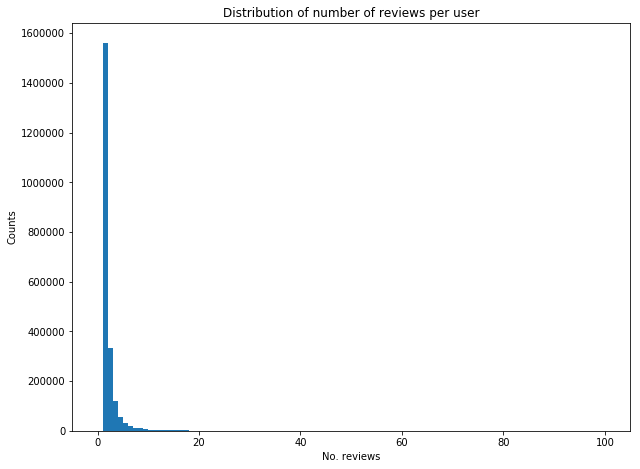

In [8]:
def myhist( data, title, xlab, n_bins = 100, density = False, range = [0,100] ):
    fig = plt.figure( figsize=(10,7.5) )
    ax = plt.gca()
    n, bins, patches = ax.hist( data, bins = n_bins, density = density, range = range )
    plt.xlabel( xlab )
    if density:
        plt.ylabel( "Density" )
    else:
        plt.ylabel( "Counts" )
    plt.title( title )

myhist( usedf.groupby( "user" ).size(), "Distribution of number of reviews per user", "No. reviews" )

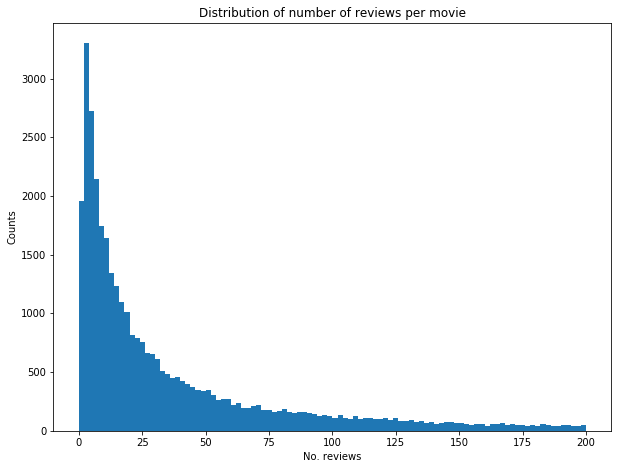

In [9]:
myhist( usedf.groupby( "item" ).size(), "Distribution of number of reviews per movie", "No. reviews", range = [0,200] )

In [10]:
print("The number of users is", usedf.user.unique().size)
print("The number of movies is", usedf.item.unique().size)

The number of users is 2189850
The number of movies is 38995


We can find that the vast majority of users rate fewer than 25 movies, which means that most users do not express their opinions for more than $ 1 - \frac{38970}{38995}\approx 0.01\%$ of movies. The distribution of number of reviews per movie generally clusters under 200. This means that most movies do not get any comments from more than $1 - \frac{2189650}{2189850}\approx 0.01\%$ users. These numbers may suggest that the dataset is quite sparse; i.e. it contains a lot of "missing data". This corroborates our statement earlier regarding neighborhood-based comparison models; namely, that each user reviews relatively few items, and in fact each item is reviewed by relatively few users (even though on average it is considerably higher than the former).

We can also compute the average rating of reviews in the dataset, and plot a histogram of all the ratings in the dataset:

The average rating of all reviews in the dataset is 4.30


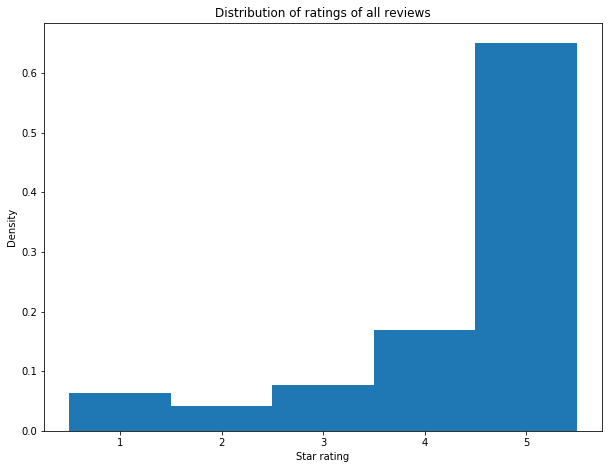

In [11]:
print("The average rating of all reviews in the dataset is %.2f" % usedf.rating.mean())
myhist( usedf.rating, "Distribution of ratings of all reviews", "Star rating", 
       n_bins = np.linspace( 0.5, 5.5, num = 6 ), density = True, range = [0,6]  )

We can see the histogram is not uniform; there is a non-significant fraction (~8%) of 1 ratings, and a large cluster of 5 ratings. This is very common in movie reviews.

### Creating a smaller dataset

Let's now create a smaller dataset in DataFrame `smalldf` by looking for those movies with more than 2,200 reviews (hot/classic movies) and those users with more than 65 reviews. Note that while this cut makes sure we have prolific users, the cut on movies restores sparsity by reducing the number of reviews per user. We also include in `smalldf` a column `user_mean` to indicate the average rating a user gives and a column `movie_mean` to indicate the average rating this movie receives. After the initial filtering, we further remove users that now have fewer than 6 reviews and movies with fewer than 3 reviews:

In [12]:
#get subset
df1 = usedf.groupby("user").size().reset_index(name="count_user")
df2 = usedf.groupby("item").size().reset_index(name="count_movie")

usedf1 = usedf.merge(df1, 'left', on = 'user').merge(df2, 'left', on = 'item')

smalldf = usedf1[(usedf1.count_movie > 2200) & (usedf1.count_user > 65)]
mean_user = smalldf.groupby("user").rating.mean().reset_index(name="user_mean")
mean_movie = smalldf.groupby("item").rating.mean().reset_index(name="movie_mean")

smalldf = smalldf.merge(mean_user, 'left', on = 'user').merge(mean_movie, 'left', on = 'item')
smalldf = smalldf.drop(["count_user","count_movie"], axis = 1)

# filter out reviewers with too few reviews
tmp = smalldf.groupby('user').size()
smalldf = smalldf[smalldf.user.isin(tmp.index[tmp>5])]

# filter out movies with too few reviews
tmp_mov = smalldf.groupby('item').size()
smalldf = smalldf[smalldf.item.isin(tmp_mov.index[tmp_mov>2])]

In [13]:
smalldf.head()

,user,item,rating,user_mean,movie_mean
0,A101IGU6UDKW3X,0767853636,5.0,4.47619,4.242424
1,A101IGU6UDKW3X,0790729628,5.0,4.47619,4.429741
2,A101IGU6UDKW3X,0792158202,5.0,4.47619,4.655172
3,A101IGU6UDKW3X,6300213986,4.0,4.47619,4.801282
4,A101IGU6UDKW3X,6304176287,5.0,4.47619,4.546512


We can repeat the exploratory analysis from the previous section that we performed on `usedf`, on `smalldf` instead:

The number of users is 778.
The number of movies is 173.


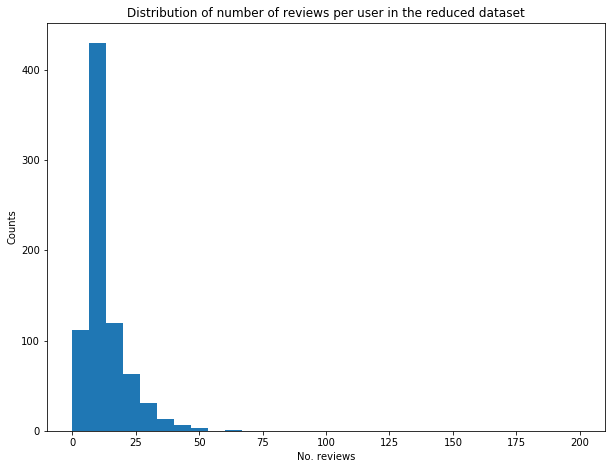

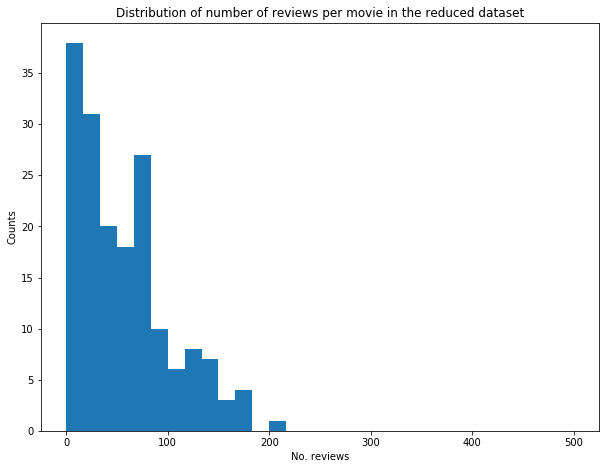

In [14]:
#repeat ex2
myhist( smalldf.groupby("user").size(), 
       "Distribution of number of reviews per user in the reduced dataset", "No. reviews", n_bins = 30, range = [0,200] )
myhist( smalldf.groupby("item").size(), 
       "Distribution of number of reviews per movie in the reduced dataset", "No. reviews", n_bins = 30, range = [0,500] )

print( "The number of users is %d." % smalldf.user.unique().size )
print( "The number of movies is %d." % smalldf.item.unique().size )

We can find the number of reviews per user mainly cumulates below 50, which means that most users do not express their opinion for about $\frac{123}{173}\approx 71\%$ movies. As for the number of reviews per movie, it mainly cumulates below 200, which means for most movies not get any comments from about $\frac{578}{778}\approx 74\%$ users. Comparing with the full dataset, the sparsity is reduced (99.99% to 71% and 74% respectively).

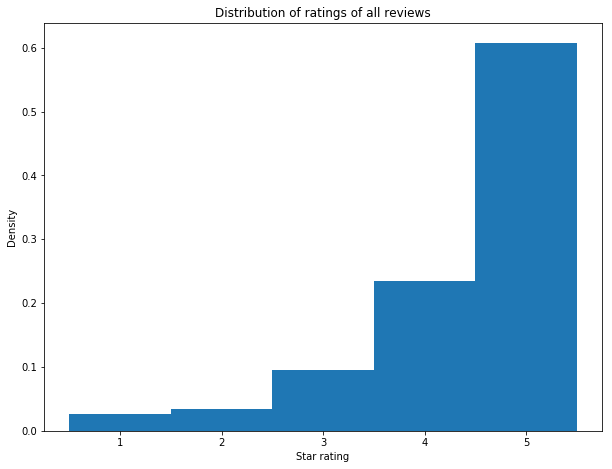

In [15]:
myhist( smalldf.rating, "Distribution of ratings of all reviews", "Star rating", 
       n_bins = np.linspace( 0.5, 5.5, num = 6 ), density = True, range = [0,6]  )

The distribution shifted from a 'U-shape' to a unimodal distribution peaked at 5-stars. This is because the movies with more reviews tend to be better than those that receive fewer reviews.

## Our first baseline recommender

Let's say the average rating of movies in Amazon is 3.5. *The Fellowship of the Ring* is better than most of the movies, and the average rating for it is probably 1.3 above the global average (over all users). However, you are quite strict about giving 5 stars to any films and tend to rate all movies 0.5 stars below the average. Thus, a baseline estimate for your rating of *The Fellowship of the Ring* is 3.5+1.3-0.5=4.3.

A baseline estimate, such as that illustrated above, takes into account systematic tendencies for some users who give lower ratings across the board than others (and vice versa). We can write the baseline estimate for an unknown rating $\text{Rating}_{um}$ for user $u$ and movie $m$ as:

$$
\text{Baseline Rating}_{u}(m) = \text{Global average} + \text{Movie deviation}_m + \text{User deviation}_u
$$

where $\text{Global average}$ is the average rating across all movies and all users. The unknown values $\text{Movie deviation}_m$ and $\text{User deviation}_u$ indicate the deviations, of user $u$ and item $m$, respectively, from the global average.

The simplest thing to start with, to get an estimate for $\text{Movie deviation}_m$ and $\text{User deviation}_u$, is the following:

$$
\text{Movie deviation}_m = \text{Average rating}_m - \text{Global average}\\
\text{User deviation}_u = \text{Average rating}_u - \text{Global average}
$$

This is directly motivated by the example above: $\text{Movie deviation}_m$ is the deviation of ratings for movie $m$ to the global average rating and $\text{User deviation}_u$ is the deviation of ratings from user $u$ to the global average rating.

### Question:

Can you critique the above idea?

----------

The following code takes the DataFrame and a user ID and returns a list of baseline estimate of ratings for all movies:

In [16]:
def baseline_recommend( df, user ):
    user_mean = df[df.user == user].rating.mean()
    movie_mean = df.groupby('item').rating.mean()
    return user_mean + movie_mean - df.rating.mean()

### Exercise 2:

Let's make some recommendations. List 10 movies with highest estimated rating for user `A101IGU6UDKW3X`, based on dataset `smalldf`. Note that you can use the dictionary `movie_title_dict` to map movie IDs to movie titles.

**Answer.**

----------

### Question:

How can you improve the baseline rating above?

## One step further: the nearest-neighbor global recommendation

The baseline estimate we just implemented is rather crude. This is because that baseline estimates only use information about *this* particular user and *this* particular movie.

For any given user, we can do a better job of recommending by finding movies that are similar to what he/she has already seen and are highly rated. This really is the idea of **collaborative filtering**: to borrow information from other users and their preferences. This approach requires a similarity measure for a pair of movies. Potential candidates include [cosine similarity](http://en.wikipedia.org/wiki/Cosine_similarity), [pearson coefficient](http://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient), and other distance-based measures. Here, we will use the Pearson coefficient. This measures the tendency of two similar users to rate two similar items similarly. Since most ratings are unknown, it is computed on the "common user pool", which is the set of common raters of a pair of movies.

Let's discuss how we calculate similarity in a bit more detail. For two movies $u$ and $v$, we find all users that rated both of them and compute the Pearson coefficient between those two sets of ratings. Intuitively, if the coefficient is close to 1, these two movies have similar merits. We compute the similarity between $u$ and all other movies and select the top $k$ movies with the highest Pearson coefficients as candidates for recommendation, provided a user actually likes movie $u$.

### Exercise 3:

Can you give some criticisms of the above idea? 

**Answer.**

----------

Let's implement this simpler global recommender step-by-step.

### Exercise 4:

Write a function to find the common users who rated both `mov1` and `mov2`. The input of this function should be the dataset and the two movie IDs. This function should return a list of user IDs who reviewed both movies. Use this function to plot a histogram of the distribution of the number of common reviewers for all pairs of movies based on `smalldf`. What is the average number of common reviewers?

**Answer.**

----------

As you can see, even though we chose a subset of the DataFrame in which every movie had at least 1,000 reviews and every user had reviewed at least 100 movies, the number of common reviewers of most pairs of movies is quite low. Let's now write a function to calculate the similarity between two movies, based on their common reviewers:

### Exercise 5:

Use function `personr` from `scipy.stats.stats` to calculate the similarity between two movies. If two movies have no or only one common reviewer, default this to zero. If one or both of the rating vectors have zero variance, we leave it to be `nan`, the default output from `pearsonr`. This function should take three inputs, a DataFrame and two movie IDs. This function should return the Pearson coefficient along with the number of common reviewers in a tuple. With this function, calculate the similarity between movies `0767853636` and `0790729628`.

**Answer.**

----------

The absolute value of rating is not directly comparable across users. This is because people tend to have different criteria when giving scores, even if overall rating of a movie is similar. Our solution to this is to extract the user's average score from the score of a specific movie before calculating the Pearson coefficient. The reason that these two movies in Exercise 5 are negatively correlated is mainly driven by the fact that there are a few reviewers whose ratings for the first movie are much higher than their ratings for the second movie.

To speed up the computation for the following sections of this case, we now write a function `pearson_sim` to build a pairwise similarity dataframe between movies in the `smalldf`. The key is the form of `mov1|mov2` where `mov1` and `mov2` are in alphabetical order:

In [17]:
def pearson_sim_dict( df ):
    ret_dict = {}
    for mov1, mov2 in combinations(df.item.unique(), 2):
        key = "|".join(sorted([mov1, mov2]))
        ret_dict[key] = pearson_sim( df, mov1, mov2 )
    return ret_dict

In [18]:
psim_dict = pearson_sim_dict(smalldf)

NameError: name 'combinations' is not defined

### $k$ - nearest movies

We are now going to find the top $k$ most similar movies to a given movie using the similarity measure we implemented above in `pearson_sim`. We can directly use the output from `pearson_sim`, but if the number of common reviewers for a pair of movies is small (e.g. say there are only two common reviewers), the similarity is very likely to be driven by the individual taste of one of the reviewers and thus need not reflect a general trend. To overcome this, we introduce a regularization approach to shrink the output from `pearson_sim` based on the size of the common reviewer set:

$$ sim_{ij} = \frac{N_{common}}{N_{common}+reg} \, \rho^\text{Pearson} _{ij}$$

where $N_{common}$ is the size of the common reviewer set and $\rho^\text{Pearson}_{ij}$ is the Pearson correlation coefficient between movies $i$ and $j$.

Roughly speaking, the above regularization pulls the estimate of similarity in toward a conservative point (0). The strength of the shrinkage decreases as the number of common reviewers increases. Since we believe 10 common reviewers is a relatively reliable source of information, we can set `reg` to be 3. The function `shrunk_sim` which takes the `sim` and `n_common` from the output of `pearson_sim` calculates the regularized similarity.

In [ ]:
def shrunk_sim(sim, n_common, reg=3.):
    ssim=(n_common*sim)/(n_common+reg)
    return ssim

### Exercise 6:

Let's write a function to find the $k$ - nearest movies of a given movie `mov`. The input of this function should be a DataFrame of reviews, a movie ID `mov`, a list of candidate movies `mov_list`, the similarity dictionary `sim_dict`, the value of $k$ and the strength of shrinkage `reg`. The output should be a sorted list of the top $k$ similar movies to `mov`, sorted by the regularized similarity. Each element of this list should contain the movie ID, the regularized similarity, and the number of common reviewers. 

**Answer.**

----------

Now, let us use this function to find the 7-nearest neighbors of movie `B001AVCFJM` and `6304176287`. You should use the dictionary `movie_title_dict` to get the actual titles for all the selected movies.

In [ ]:
tops=knearest( smalldf, 'B001AVCFJM', smalldf.item.unique(), psim_dict )
print("For ", movie_title_dict['B001AVCFJM'], ", top matches are:")
for i, (movid, sim, nc) in enumerate(tops):
    print(i, movie_title_dict[movid], "| Sim", sim, "| Common Reviewers",nc)

In [ ]:
tops2=knearest( smalldf, '6304176287', smalldf.item.unique(), psim_dict)
print("For ", movie_title_dict['6304176287'], ", top matches are:")
for i, (movid, sim, nc) in enumerate(tops2):
    print(i, movie_title_dict[movid], "| Sim", sim, "| Common Reviewers",nc)

We can see the most similar movies, based on common reviewers' ratings, do bear some resemblance with the targeted movie.

### Exercise 7:

Write a function to first find the top `k1` movies a user has rated and then find all movies that are the `k2` nearest neighbors of these top rated movies, but which have not been seen by the user yet. The input of this function is a DataFrame of reviews, a user ID, a similarity dictionary, and the values of `k1` and `k2`. The output is a list and each element of it is another list containing the title of the movie and its average rating across all reviewers. The output should be sorted by the average ratings from largest to smallest.

**Answer.**

----------

Now let's use `recommend_global` to make recommendations for user `A101IGU6UDKW3X`. We set `k1=5`, `k2=7` and `reg=3.0`.

In [ ]:
res = recommend_global( smalldf, 'A101IGU6UDKW3X', psim_dict, k1 = 5, k2 = 7, reg = 3.0)
print("Recommendation for User A101IGU6UDKW3X:")
for mov, rate in res:
    print(movie_title_dict[mov], "|", np.round(rate,2))

## A user-based nearest-neighbors recommender with predicted ratings

We can now provide recommendations based on global similarities. However, in many cases this is not enough.

For example, it is hard to judge if the above recommendations are any good. Notice that so far, we only make recommendations but do not estimate the rating that user would give to the recommended movie. In this section, we shift our focus to predicting what _rating_ a user would give to a movie they have never seen before. To do this, we will leverage the information from movies that the user has rated.

To be more specific, we will now modify the baseline estimate of rating by the following specification:

$$ \text{Rating}_{u}(m) = \text{Baseline Rating}_{u}(m)\, + \,\frac{\sum\limits_{j \in S(k)} sim_{mj} ( \text{Rating given by the user}_{u}(j) - \text{Baseline Rating}_{u}(j) )}{\sum\limits_{j \in S(k)} sim_{mj} } $$

where $S(k)$ is the $k$ neighbor movies of movie $m$ which have been rated by user $u$ and $sim_{mj}$ is similarity between movie $m$ and movie $j$. The idea here is to pull the estimate of rating for movie $u$ towards the observed ratings of movies that are "similar" to it.

We now write a function `knearest_userrated`, analogous to the `knearest` function we defined above, to find the nearest `k` neighbors to a given movie from the **movies that the user has already rated**. This function will take as arguments the DataFrame of reviews, `mov_id`, `user_id`, `sim_dict`, `k`, and the regularizer `reg`. Just like before, we return a *k-length sorted list* of 3-tuples each corresponding to a movie:

In [ ]:
def knearest_userrated( df, mov_id, user_id, sim_dict, reg, k = 7 ):
    return knearest( df, mov_id, df[df.user == user_id].item, sim_dict, reg = reg, k = k )

Let's now write a function that returns the predicted rating for a user and a movie using the formula at the beginning of this section. If the sum of scores that goes in the denominator is 0, we will return a predicted rating of the baseline portion of the formula in that case. Also, if the estimated rating is smaller than 0, we set it to be 0 and if the estimated rating is larger than 5, we set it to be 5. This function `rating` takes as arguments the dataframe of review, `mov_id` and `user_id` of interest, similarity dictionary `sim_dict` and `k` as well as the regularizer:

In [ ]:
def rating( df, mov_id, user_id, sim_dict, reg, k = 7 ):
    # seperate three fields from the output of knearest_userrated
    id_k, sim_k, sup_k = map( list, zip( *knearest_userrated( df, mov_id, user_id, sim_dict, reg = reg, k = k ) ) )
    
    #calculate baseline
    baseline_all = baseline_recommend(df, user_id)
    obs = df[(df.user==user_id)&(df.item.isin(id_k))].rating
    
    rating_adj = baseline_all[mov_id] + np.dot(np.array(obs) - np.array(baseline_all[id_k]), sim_k)/np.sum(sim_k)
    
    #handle cases where the denominator is zero
    if np.abs(np.sum(sim_k))<1e-3:
        rating_adj = 0
    #get rid of nan
    if np.isnan(rating_adj):
        rating_adj = 0
    
    return rating_adj

Now let's use the function `rating` to predict the rating of user `A101IGU6UDKW3X` for movies that are recommended by the global recommender in Exercise 7:

In [ ]:
print("User Average", smalldf[smalldf.user=='A101IGU6UDKW3X'].rating.mean(),"for User", 'A101IGU6UDKW3X')
print("Predicted ratings for top choices calculated earlier:")
for mov_id, mov_score in res:
    print(movie_title_dict[mov_id],"|",np.round(rating(smalldf, mov_id, 'A101IGU6UDKW3X', psim_dict, k=7, reg=3.),2),"|","Average", np.round(mov_score,2))

Note the global average rating for these movies do not have the same order as the predicted rating for this user. This indicates a personalized recommendation is made using the function `rating`.

## Error analysis of the predicted ratings

Let's compare the predicted ratings with a user's actual ratings. Ideally, we should conduct cross-validation and estimate the rating for every review in the dataset using an external dataset. But since the dataset is rather large, cross-validation would be very time-consuming. For illustrative purposes, we will split `smalldf` into a test and a training set and proceed from there.

### Exercise 8:

Split `smalldf` into training and test sets where the training set contains 90% of the reviews. Predict the ratings for reviews in the test set and use the function `compare_results` (provided below) to compare the predicted ratings and the actual ratings. Examine three scenarios: `k=3, reg=3`, `k=3, reg=15`, `k=10, reg=3`.

In [ ]:
def compare_results(rating_actual, rating_predicted, ylow=-10, yhigh=15, title=""):
    from sklearn.metrics import mean_squared_error
    fig=plt.figure()
    df=pd.DataFrame(dict(actual=rating_actual, predicted=rating_predicted))
    ax=plt.scatter(df.actual, df.predicted, alpha=0.2, s=30, label="predicted")
    plt.ylim([ylow,yhigh])
    plt.plot([1,5],[1,5], label="slope 1")
    df_mean=df.groupby('actual').predicted.mean().reset_index()
    df_sig=df.groupby('actual').predicted.std().reset_index()
    
    # only plot means with variance estimate
    df_mean = df_mean[~np.isnan(df_sig.predicted)]
    df_sig = df_sig[~np.isnan(df_sig.predicted)]
    plt.plot(df_mean['actual'], df_mean['predicted'],'k', label="means")
    plt.fill_between(df_sig['actual'], df_mean['predicted']-df_sig['predicted'],
                     df_mean['predicted']+df_sig['predicted'], color='k', alpha=0.2)
    
    plt.xlabel("actual")
    plt.ylabel("predicted")
    plt.legend(frameon=False)
    plt.grid(False)
    plt.title(title)
    print("MSE:", mean_squared_error(rating_actual, rating_predicted))

**Answer.**

----------

### Capping the estimates of ratings for smaller variance

As we can see, the variances of the estimates from the simiarity approach are quite large. The main reason is that many estimates are either larger than 5 or smaller than 0, which are outside the range of actual ratings. We can reduce the variance by capping the estimates to make them between 0 and 5. We implement it in `rating_cap`:

In [ ]:
def rating_cap( df, mov_id, user_id, sim_dict, reg, k = 7 ):
    # seperate three fields from the output of knearest_userrated
    id_k, sim_k, sup_k = map( list, zip( *knearest_userrated( df, mov_id, user_id, sim_dict, reg = reg, k = k ) ) )
    
    #calculate baseline
    baseline_all = baseline_recommend(df, user_id)
    obs = df[(df.user==user_id)&(df.item.isin(id_k))].rating
    
    rating_adj = baseline_all[mov_id] + np.dot(np.array(obs) - np.array(baseline_all[id_k]), sim_k)/np.sum(sim_k)
    
    #handle cases where the denominator is zero
    if np.abs(np.sum(sim_k))<1e-3:
        rating_adj = 0
    #get rid of nan
    if np.isnan(rating_adj):
        rating_adj = 0
    
    if rating_adj<0:
        rating_adj = 0
    if rating_adj>5:
        rating_adj = 5
    
    return rating_adj

We repeat the same analyses in Exercise 8 and the results are listed below:

In [ ]:
predict = [rating_cap(train, test.item.iloc[i], test.user.iloc[i], sim_dict, k=3, reg=3.) for i in range(test.shape[0])]
compare_results( test.rating, predict, title = "Prediction performance k=3, reg=3" )

In [ ]:
predict = [rating_cap(train, test.item.iloc[i], test.user.iloc[i], sim_dict, k=3, reg=15.) for i in range(test.shape[0])]
compare_results( test.rating, predict, title = "Prediction performance k=3, reg=15" )

In [ ]:
predict = [rating_cap(train, test.item.iloc[i], test.user.iloc[i], sim_dict, k=10, reg=3.) for i in range(test.shape[0])]
compare_results( test.rating, predict, title = "Prediction performance k=10, reg=3" )

It is clear that after capping, the overall MSE is significantly reduced. However, we also find, based on the figures, that the estimated ratings tend to have higher bias, as reflected by the deviation of black curves to the blue curve in each figure. This illustrates the typical trade-off between bias and variance.

## Latent factor based recommendations: nonnegative matrix factorization

Let's now proceed to using a latent-factor based approach to construct a recommendation system. The way to extract these latent factors is **non-negative matrix factorization (NMF)**.

### The latent factor model

#### Model overview

The central idea in constructing a recommendation system using collaborative filtering is that *similar users will rate similar movies similarly*. In the previous sections, we explicitly implemented this idea by using similarity measure. We also assumed that either all users were the same (the global approach) or that only the current user was similar enough to make a recommendation (the user-specific approach). In this section, we will use a model that allows us to identify both similar users and similar movies as a function of **latent factors**.

We can think of latent factors as properties of movies (e.g., genre, price, running time) that users have a positive or negative preference for. We do not observe these factors or the users' preferences directly, but we assume that they affect how users tend to rate movies. For example, an extremely long movie would receive a low rating if the reviewer prefers fast-paced titles. Note that if users have similar preferences, then according to the model, they will behave similarly, and likewise, if movies have similar latent factors, they will be rated similarly by similar users.

One issue that comes up with latent factor models is determining how many latent factors to include. We can deal with the problem of choosing the number of latent factors with cross-validation.

#### Rating model specification

Let's denote the actual rating of movie $m$ from user $u$ as $Y_{um}$. In our dataset, we have $N$ distinct users and $M$ distinct movies. Not all combinations of movies and users have ratings. We assume there are $L$ reviews in total. The latent factor model we specify assumes that each movie is associated with a $K$-dimensional latent factor $v_m$ and each user is associated with a $K$-dimensional latent factor $w_u$. Furthermore, we assume that:

$$
Y_{um} = v_m^\intercal w_u
$$

Note that under this model specification, if two movies have very similar $v_m$, the associated score $Y$ from any user should be similar. And if two users have very similar $w_u$, their ratings for any movie should also be very similar. The following figure provides a very clear summary of the model specification:
![](factor_model.png)
*Image from this [website](https://medium.com/@connectwithghosh/simple-matrix-factorization-example-on-the-movielens-dataset-using-pyspark-9b7e3f567536)*

#### Estimation for this model

Using this model, we want to estimate $v$ and $w$ for all users and all movies, before which $K$ is also important to determine. There are numerous ways to estimate these quantities but we are going to focus on non-negative matrix factorization (NMF) in this section. The idea of this approach is that both $w$ and $v$ have to be non-negative vectors. This constraint makes the prediction for any unobserved review non-negative and discourages extremely high predicted ratings, which is the major advantage of the NMF approach compared to the approach we introduced previously.

No matter what the implementation of the matrix factorization we are using, the ultimate goal in estimation is to approximate the observed ratings as closely as possible. This is usually achieved by minimizing the mean squared error of the predicted ratings for reviews that are available in the training dataset.

We provide function `recommend_nmf` based on package `surprise` to predict ratings of a specific user for a specific movie. The input is a DataFrame of reviews and the number of latent factors. The output is a fitted `algo` object:

In [ ]:
def recommend_nmf(df, K):
    from surprise import NMF
    from surprise import Reader, Dataset
    
    reader = Reader()
    data = Dataset.load_from_df(df[['user', 'item', 'rating']], reader)
    trainset = data.build_full_trainset()
    algo = NMF(n_factors=K)
    algo.fit(trainset)
    return algo

### Exercise 9:

Using `recommend_nmf` to estimate the ratings for reviews in `test` based on `train` in Exercise 8. Visualize the results as in Exercise 8 for `K=5`, `K=20`, `K=50`. Based on the results, do you prefer the NMF method or the nearest-neighbor method?

**Answer.**

----------

### Effect of $K$ on the prediction accuracy

To further visualize the effect of $K$ on the prediction accuracy of the ratings, we plot the MSE as a function of $K$:

In [ ]:
from sklearn.metrics import mean_squared_error
mse_all = []

for K in range(2,51):
    rec_K = recommend_nmf(train, K=K)
    pred_K = [rec_K.predict(test.user.iloc[i], test.item.iloc[i]).est for i in range(test.shape[0])]
    mse_all.append(mean_squared_error(test.rating, pred_K))

In [ ]:
plt.plot(range(2,51), mse_all);
plt.xlabel("Number of latent factors (K)");
plt.ylabel("MSE in testing set");
plt.title("Prediction accuracy of NMF model when K changes")

When $K$ increases, the model fits the data more accurately. However, this does not directly imply the prediction accuracy of the trained model will also be increased when evaluated on an external test set. The curve we show above shows that if $K$ is too large ($>20$), the MSE of the test set actually increases, indicating overfitting of the model to the training data. This plot can serve as a way to select $K$ in practice.

## Conclusion

In this case study, we constructed recommedation systems for movies based solely on reviews data. Our first recommender examined the correlation between reviews of common reviewers and used the correlation to assign similarity between movies. We also introduced an alternative recommendation system constructed by directly decomposing the item-user matrix into low-dimensional latent factors and used the identified latent factors to estimate a user's rating for a yet un-viewed movie. By sorting the estimated rating, a list of recommended items can be generated.

We find that the first approach tends to have lower bias but higher variance whereas the second approach produces low variance predictions with elevated bias. We also note that the second approach is computationally more efficient. Considering the fact that the data available to us will continue to increase, the second approach is probably the better choice.

## Takeaways

In this case, we introduce two approaches for movie recommendation: nearest-neighbor approach and matrix factorization approach. Both approaches are proposed to deal with the high sparsity in review dataset and each with its own pros and cons. We find in general, matrix factorization approach is computationally more efficient with smaller uncertainty for the predicted ratings. Nearest-neighbor approach on the other hand, is computationally intensive due to the calculation of pairwise similarity. It is more unstable in prediction for ratings compared to MF approach but has smaller bias. Unfortunately, neither of these two approaches can deal with the issue of new item. In our next case, we should address this issue by using external information about users and movies.